In [1]:
import pandas as pd
import os
import nibabel as nib
import pydicom as dicom
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm_notebook
from torch.cuda.amp import GradScaler, autocast
import wandb
from skimage.transform import resize
from sklearn.metrics import roc_auc_score
from loguru import logger
import random
from monai.networks.nets import EfficientNetBN
from monai.networks.nets import resnet10, resnet18, resnet34
import time
from sklearn.model_selection import train_test_split
import optuna
from sklearn.model_selection import StratifiedKFold
from IPython.display import HTML
from monai import transforms 

In [2]:
torch.manual_seed(383)
random.seed(383)
np.random.seed(383)

# Read data

In [3]:
df = pd.read_csv("Data/MGMT.csv")
df.head()

,files,labels,x,y
0,BraTS2021_00000,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
1,BraTS2021_00002,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
2,BraTS2021_00003,0,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
3,BraTS2021_00005,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
4,BraTS2021_00006,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...


In [4]:
## df["labels"].value_counts(normalize=True)

In [5]:
train = pd.read_csv("Data/TRAIN.csv")
# val = pd.read_csv("Data/VAL.csv")
test = pd.read_csv("Data/TEST.csv")

In [6]:
df_train = df[df["files"].isin(train["files"].to_list())].sample(frac=1, random_state=0).reset_index(drop=True)
# df_val = df[df["files"].isin(val["files"].to_list())].sample(frac=1, random_state=0).reset_index(drop=True)
df_test = df[df["files"].isin(test["files"].to_list())].sample(frac=1, random_state=0).reset_index(drop=True)

In [7]:
df_train.head()

,files,labels,x,y
0,BraTS2021_00305,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
1,BraTS2021_00768,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
2,BraTS2021_00120,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
3,BraTS2021_00395,0,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
4,BraTS2021_00021,0,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...


# Custom data loader

In [8]:
def get_data(img):
    
    data = img.get_fdata()
    
    for i, aff in enumerate(np.diag(img.affine)[:-1]):
        if aff < 0:
            data = np.flip(data, axis=i)

    return data

In [9]:
df_train.head()

,files,labels,x,y
0,BraTS2021_00305,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
1,BraTS2021_00768,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
2,BraTS2021_00120,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
3,BraTS2021_00395,0,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
4,BraTS2021_00021,0,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...


In [10]:
files = {}

for f in os.listdir('/data/slow/RSNA_ASNR_MICCAI_BraTS2021_TrainingData/BraTS2021_00305/'):
    files[f] = get_data(nib.load("/data/slow/RSNA_ASNR_MICCAI_BraTS2021_TrainingData/BraTS2021_00305/" + f)).astype(np.float32)

In [11]:
files.keys()

dict_keys(['BraTS2021_00305_seg.nii.gz', 'BraTS2021_00305_flair.nii.gz', 'BraTS2021_00305_t1.nii.gz', 'BraTS2021_00305_t1ce.nii.gz', 'BraTS2021_00305_t2.nii.gz'])

Text(0.5, 1.0, 'T2')

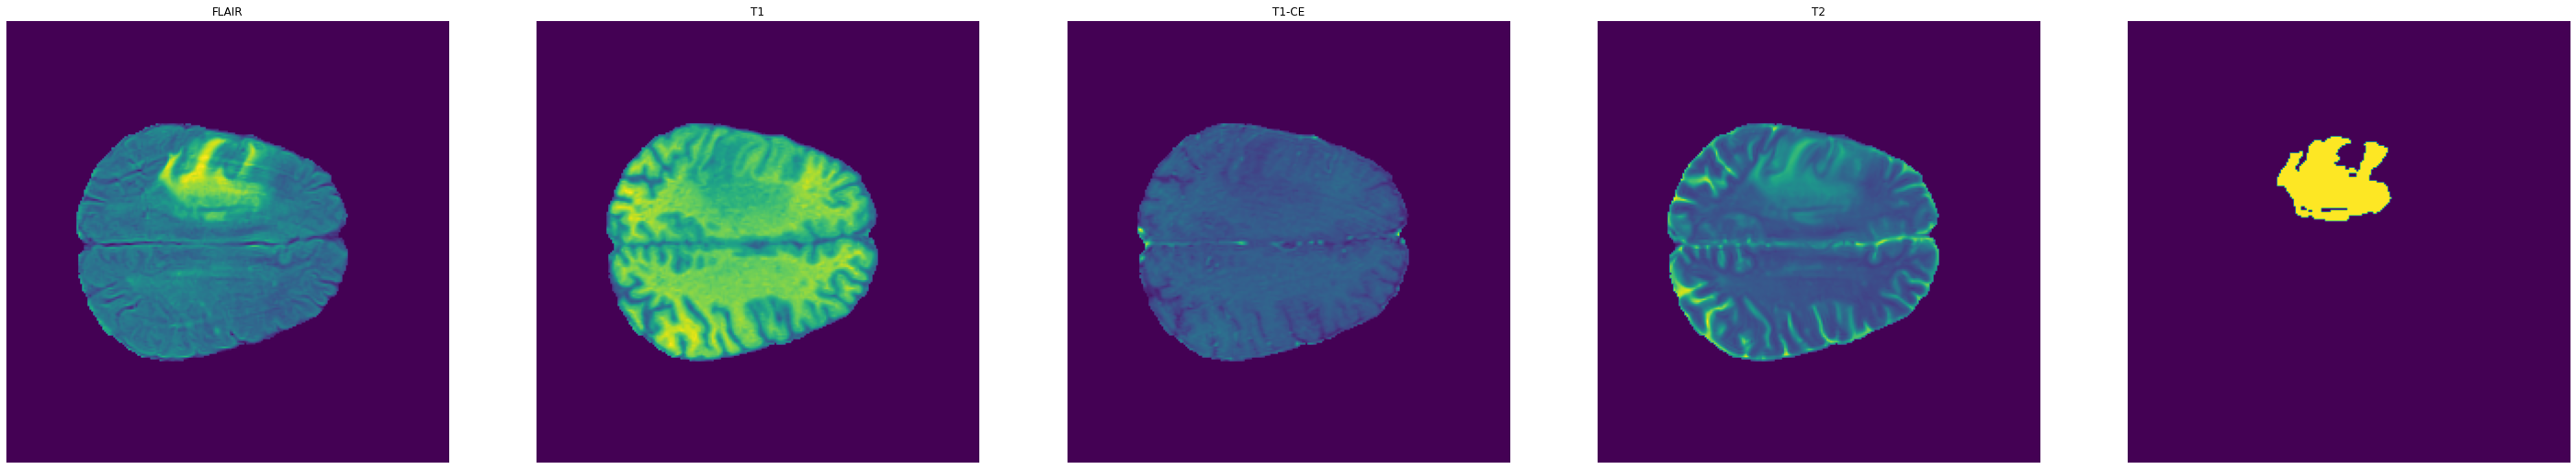

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(50, 100))

ax[0].imshow(files["BraTS2021_00305_flair.nii.gz"][:,:,100])
ax[1].imshow(files["BraTS2021_00305_t1.nii.gz"][:,:,100])
ax[2].imshow(files["BraTS2021_00305_t1ce.nii.gz"][:,:,100])
ax[3].imshow(files["BraTS2021_00305_t2.nii.gz"][:,:,100])
ax[4].imshow(files["BraTS2021_00305_seg.nii.gz"][:,:,100])


ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")
ax[4].axis("off")

ax[0].set_title("FLAIR")
ax[1].set_title("T1")
ax[2].set_title("T1-CE")
ax[3].set_title("T2")

# ax[0].imshow(y[:,:,100], alpha=0.65)

# ax[1].imshow(x[100,:,:])
# ax[1].imshow(y[100,:,:], alpha=0.65)

# ax[2].imshow(x[:,100,:])
# ax[2].imshow(y[:,100,:], alpha=0.65, cmap="Reds")

# ax[0].axis("off")
# ax[1].axis("off")
# ax[2].axis("off")

# fig.savefig("brats.png", dpi=200)
# plt.gcf().set_facecolor("red")


In [13]:
x = get_data(nib.load(df_train["x"].iloc[0])).astype(np.float32)

In [14]:
y = get_data(nib.load(df_train["y"].iloc[0])).astype(np.float32)

(-0.5, 154.5, 239.5, -0.5)

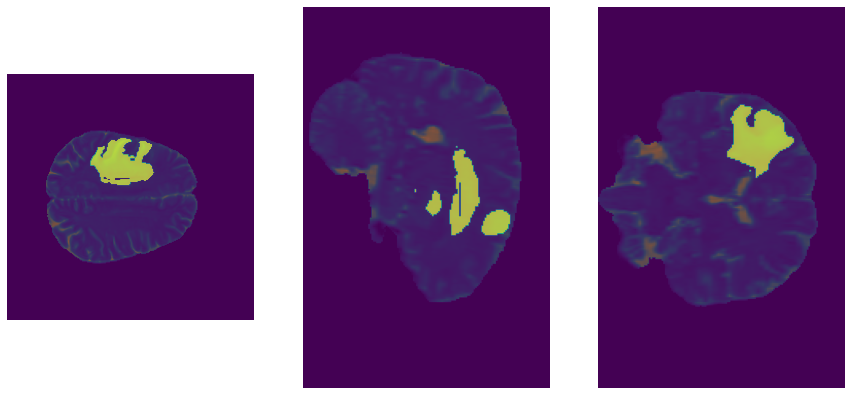

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 20))

ax[0].imshow(x[:,:,100])
ax[0].imshow(y[:,:,100], alpha=0.65)

ax[1].imshow(x[100,:,:])
ax[1].imshow(y[100,:,:], alpha=0.65)

ax[2].imshow(x[:,100,:])
ax[2].imshow(y[:,100,:], alpha=0.65)

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

# fig.savefig("BRAIN.png")
# plt.gcf().set_facecolor("red")


In [16]:
class MRI_LoaderAugmentation(Dataset):
    def __init__(self, brain, target, transform):
        self.files_brain = brain
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.files_brain)

    def __getitem__(self, idx):
        
        x = self.files_brain[idx]
        y = self.target[idx]
#         mask = self.files_mask[idx]
    
        x = get_data(nib.load(x)).astype(np.float32) #.get_fdata()
#         mask = nib.load(mask).get_fdata().astype(np.uint8)
        
#         x = x.transpose(2, 0, 1)
#         mask = mask.transpose(2, 0, 1)
#         mask[mask > 1] = 1
        
#         x = resize(x, (128, 128, 128))
        x = resize(x, (64, 64, 64))
    
#         x = resize(x, (32, 32, 32))
            
#         mask = x.copy()
#         mask[mask != 0] = 1
#         bool_mask = mask != 0
        
        if self.transform is not None:
        
            x = np.expand_dims(x, 0)
            
            x = self.transform(x)
            
            x = x[0]
        
        #Normalization
#         x[bool_mask] = (x[bool_mask] - x[bool_mask].mean())/(x[bool_mask].std() + 1e-6)
        x = (x - x.mean())/(x.std() + 1e-6)
          
        return torch.tensor(x).unsqueeze(dim=0), torch.tensor(y).float().unsqueeze(dim=0)

In [17]:
PROB = 1

TR = transforms.Compose(
    [
#         transforms.RandRotate(prob=PROB, 
#                               range_x=(15*np.pi/180),
#                               range_y=(15*np.pi/180),
#                               range_z=(15*np.pi/180),
#                              ),
#         transforms.Rand3DElastic(
#             prob=PROB,
#             sigma_range=(0.1, 0.25),
#             magnitude_range=(0.05, 0.1)
#         ),
        transforms.RandZoom(prob=PROB, min_zoom=0.5, max_zoom=1.75),
#         transforms.RandGaussianNoise(prob=PROB, mean=250, std=250),
#         transforms.RandBiasField(prob=PROB, coeff_range=(0, 1)),
#         transforms.RandCoarseDropout(prob=PROB, holes=16, spatial_size=(16, 16), fill_value=0)        
    ]
)

In [18]:
train_loader = MRI_LoaderAugmentation(df_train["x"], df_train["labels"], TR)
train_loader = DataLoader(train_loader, shuffle=True, batch_size=32, num_workers=12)

In [19]:
for x, y in train_loader:
    break

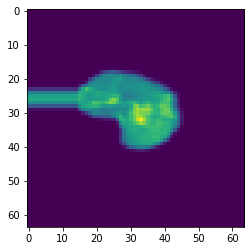

In [20]:
plt.imshow(x[5, 0, 32])

## Test data loader

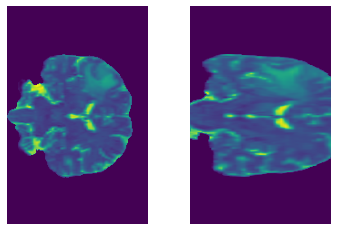

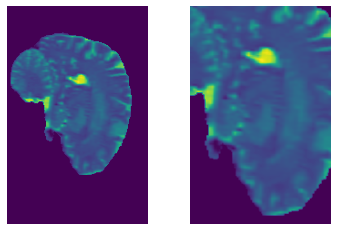

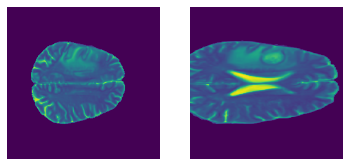

In [21]:
ori_brain = get_data(nib.load(df_train["x"].iloc[0]))

# for _ in range(5):

aug_brain = TR(ori_brain)

fig, ax = plt.subplots(1, 2) #, figsize=(10, 5))

ax[0].imshow(ori_brain[:, 100, :])    
ax[1].imshow(aug_brain[:, 100, :])

ax[0].axis("off")   
ax[1].axis("off")   
    
fig, ax = plt.subplots(1, 2) #, figsize=(10, 5))

ax[0].imshow(ori_brain[100, :, :])    
ax[1].imshow(aug_brain[100, :, :])

ax[0].axis("off")   
ax[1].axis("off") 

fig, ax = plt.subplots(1, 2) #, figsize=(10, 5))

ax[0].imshow(ori_brain[:, :, 100])    
ax[1].imshow(aug_brain[:, :, 100])

ax[0].axis("off")   
ax[1].axis("off") 

plt.show()    

In [22]:
df_temp = df.iloc[:100].copy()
df_temp.head()

,files,labels,x,y
0,BraTS2021_00000,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
1,BraTS2021_00002,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
2,BraTS2021_00003,0,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
3,BraTS2021_00005,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
4,BraTS2021_00006,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...


In [23]:
Loader = MRI_LoaderAugmentation(df_temp["x"], df_temp["labels"], TR)
Loader = DataLoader(Loader, shuffle=True, batch_size=4)

In [24]:
for x, y in Loader:
    break

In [25]:
list(x.shape)

[4, 1, 64, 64, 64]

In [26]:
# assert list(x.shape) == [4, 1, 240, 240, 155], "Error in data loader."

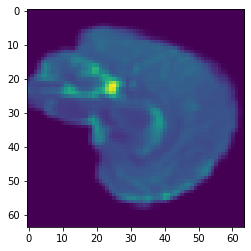

In [27]:
plt.imshow(x[0, 0, 32].numpy())
plt.show()

# Train loop

## Evaluation functions

In [28]:
def calculate_auc(df_eval):
    return roc_auc_score(df_eval["y"], df_eval["y_pred"])

In [29]:
def evaluate_model(model, loader):

    y_list = []
    y_pred_list = []
        
    for x, y in loader:
        x = x.to("cuda:0")
        y = y.to("cuda:0")            

        with torch.no_grad():
            y_pred = torch.sigmoid(model(x))
            y_list += list(y.detach().cpu().numpy().reshape(-1))
            y_pred_list += list(y_pred.detach().cpu().numpy().reshape(-1))
                
    return pd.DataFrame(data={
        "y": y_list,
        "y_pred": y_pred_list
    })

## Train function

In [30]:
def train_and_evaluation_loop(net, 
                              loss, 
                              opt, 
                              train_loader, 
                              validation_loader, 
                              test_loader,
                              epochs=1, 
                              patient=10,
                              scheduler=None,
                              name="Test training method",
                              experiment_description="First tests.",
                              mode="dev"):
        
    project = "END-TO-END-3D-MODEL-BRATS"
        
    if mode != "dev":
        run = wandb.init(project=project, entity="felipesassi", name=name)
        
        wandb.watch(net)
        
        config = wandb.config
        config["experiment_description"] = experiment_description
        config["loss"] = str(loss)
        config["optimizer"] = str(opt)
        config["epochs"] = epochs
        config["patient"] = patient
        config["batch_size"] = train_loader.batch_size
        
    best_model = None
    best_loss_per_epoch = 999999
    stop_train_counter = 0
    
    train_info = []
    val_info = []
    test_info = []
        
    for e in range(epochs):

        logger.info(f"Epoch: {e + 1}.")

        logger.info(f"Start training loop.")
 
        y_list = []
        y_pred_list = []

        loss_value_per_step = 0

#         Check this
        net.train()

        start_time = time.time()
        
        for x, y in train_loader:
            x = x.to("cuda:0")
            y = y.to("cuda:0")    

            opt.zero_grad()

            y_pred = net(x)
                
            loss_value = loss(y_pred, y)
                        
            loss_value.backward()

            opt.step()

            loss_value_per_step += loss_value.item()
            
            y_list_temp = list(y.detach().cpu().numpy().reshape(-1))
            
            y_pred = torch.sigmoid(y_pred)
            
            y_pred_list_temp = list(y_pred.detach().cpu().numpy().reshape(-1))

            y_list += y_list_temp
            y_pred_list += y_pred_list_temp

        end_time = time.time()
            
        y_array = np.array(y_list)
        y_pred_array = np.array(y_pred_list)
        
        train_loop_info = {
            "step": e,
            "loss_train": loss_value_per_step/len(train_loader),
            "auc_train": roc_auc_score(y_array, y_pred_array),
            "train_loop_duration": end_time - start_time
        }
        
        if mode != "dev":
            wandb.log(train_loop_info)
        
        logger.info(f"Train loop info: {train_loop_info}")
        
        logger.info(f"Start validation loop.")

        y_list = []
        y_pred_list = []

        loss_value_per_step = 0
        
#         Check this
        net.eval()

        start_time = time.time()
        
        for x, y in validation_loader:
            x = x.to("cuda:0")
            y = y.to("cuda:0")    

            with torch.no_grad():
                y_pred = net(x)
                loss_value = loss(y_pred, y)

                y_pred = torch.sigmoid(y_pred)
                
            loss_value_per_step += loss_value.item()

            y_list_temp = list(y.detach().cpu().numpy().reshape(-1))
            y_pred_list_temp = list(y_pred.detach().cpu().numpy().reshape(-1))

            y_list += y_list_temp
            y_pred_list += y_pred_list_temp

        end_time = time.time()
            
        y_array = np.array(y_list)
        y_pred_array = np.array(y_pred_list)
                
        validation_loop_info = {
            "step": e,
            "loss_validation": loss_value_per_step/len(validation_loader),
            "auc_validation": roc_auc_score(y_array, y_pred_array),
            "validation_loop_duration": end_time - start_time
        }
        
        auc_per_epoch = roc_auc_score(y_array, y_pred_array)
        
        if mode != "dev":
            wandb.log(validation_loop_info)
        
        logger.info(f"Validation loop info: {validation_loop_info}")

        #Early stopping 
        if loss_value_per_step < best_loss_per_epoch:
            best_loss_per_epoch = loss_value_per_step
            stop_train_counter = 0
            
            if not os.path.exists(f"Data/Models/{project}"):
                os.mkdir(f"Data/Models/{project}")
            
#             state_dict = {
#                 "epoch": e,
#                 "model_state_dict": net.state_dict(),
#                 "optimizer_state_dict": opt.state_dict(),
#                 "loss": loss,
#             }
            
            torch.save(net.state_dict(), f"Data/Models/{project}/{'_'.join(name.split(' ')).lower()}.pth")
            
            logger.info(f"New loss lower than best loss - New best loss: {loss_value_per_step:.2f}")
            
        else:
            stop_train_counter = stop_train_counter + 1
            
        if stop_train_counter > patient:
            logger.info(f"Stop training in epoch {e + 1}.")
            break
        
        if e > 1:
        
            if scheduler is not None:
                scheduler.step()
        
#         if mode != "dev":
#             if not os.path.exists(f"Data/Models/{project}"):
#                 os.mkdir(f"Data/Models/{project}")
            
#             torch.save(net, f"Data/Models/{project}/{'_'.join(name.split(' ')).lower()}.pth")
    
#     net = resnet10(spatial_dims=3, n_input_channels=1, n_classes=1)
    
#     net.load_state_dict(torch.load(f"Data/Models/{project}/{'_'.join(name.split(' ')).lower()}.pth"))
    
#     net = net.to("cuda:0")
    
        net.eval()
    
        df_eval_train = evaluate_model(net, train_loader)
        df_eval_val = evaluate_model(net, validation_loader)
        df_eval_test = evaluate_model(net, test_loader)

        auc_train = calculate_auc(df_eval_train)
        auc_val = calculate_auc(df_eval_val)
        auc_test = calculate_auc(df_eval_test)

        evaluation_info = {
                "final_auc_train": auc_train,
                "final_auc_val": auc_val,
                "final_auc_test": auc_test,
                "step": e
    #             "final_learning_rate": opt.param_groups[0]["lr"]
            }

        logger.info(evaluation_info)
    
        train_info.append(df_eval_train)
        val_info.append(df_eval_val)
        test_info.append(df_eval_test)
        
        if mode != "dev":

            wandb.log(evaluation_info)
    
    if mode != "dev":    
        run.finish()
        
    return auc_train, auc_val, train_info, val_info, test_info

# Train test

In [31]:
CUDA_LAUNCH_BLOCKING=1

In [32]:
df_train_split, df_val_split = train_test_split(df_train, 
                                                test_size=0.25, 
                                                random_state=0, 
                                                stratify=df_train["labels"])

df_train_split = df_train_split.reset_index(drop=True)
df_val_split = df_val_split.reset_index(drop=True)

In [33]:
# Teste rápido para verificar se o modelo está aprendendo

run = False

if run:

#     train_loader = MRI_LoaderAugmentation(df_temp["x"].iloc[:16], df_temp["labels"].iloc[:16], None)
#     train_loader = DataLoader(train_loader, shuffle=False, batch_size=4, num_workers=12)

#     validation_loader = MRI_LoaderAugmentation(df_temp["x"].iloc[:16], df_temp["labels"].iloc[:16], None)
#     validation_loader = DataLoader(validation_loader, shuffle=False, batch_size=4, num_workers=12)

#     test_loader = MRI_LoaderAugmentation(df_temp["x"].iloc[:16], df_temp["labels"].iloc[:16], None)
#     test_loader = DataLoader(test_loader, shuffle=False, batch_size=4, num_workers=12)
    
    train_loader = MRI_LoaderAugmentation(df_train_split["x"], df_train_split["labels"], None)
    train_loader = DataLoader(train_loader, shuffle=True, batch_size=4, num_workers=12)

    validation_loader = MRI_LoaderAugmentation(df_val_split["x"], df_val_split["labels"], None)
    validation_loader = DataLoader(validation_loader, shuffle=True, batch_size=4, num_workers=12)

#     test_loader = MRI_LoaderAugmentation(df_temp["x"].iloc[:16], df_temp["labels"].iloc[:16], None)
#     test_loader = DataLoader(test_loader, shuffle=False, batch_size=4, num_workers=12)

    test_loader = None
    
    net = resnet10(spatial_dims=3, n_input_channels=1, n_classes=1)

    net = net.to("cuda:0")
    net.train()

    epochs = 4
    loss = nn.BCEWithLogitsLoss()
    opt = optim.Adam(net.parameters())

#     train_and_evaluation_loop(net, loss, opt, train_loader, validation_loader, test_loader, epochs, patient=4, mode="dev", name="EFNETB0 1", experiment_description="First test.")

# Hold-out test

In [34]:
df_train_split, df_val_split = train_test_split(df_train, 
                                                test_size=0.25, 
                                                random_state=0, 
                                                stratify=df_train["labels"])

df_train_split = df_train_split.reset_index(drop=True)
df_val_split = df_val_split.reset_index(drop=True)

In [35]:
# df_train_split = pd.concat([df_train_split for _ in range(10)]).reset_index(drop=True)

## Train 1

In [36]:
PROB = 0.5

TR = transforms.Compose(
    [
#         transforms.RandRotate(prob=PROB, 
#                               range_x=(15*np.pi/180),
#                               range_y=(15*np.pi/180),
#                               range_z=(15*np.pi/180),
#                              ),
#         transforms.Rand3DElastic(
#             prob=PROB,
#             sigma_range=(0.1, 0.25),
#             magnitude_range=(0.05, 0.1)
#         ),
        transforms.RandZoom(prob=PROB, min_zoom=0.5, max_zoom=1.75),
#         transforms.RandGaussianNoise(prob=PROB, mean=250, std=250),
#         transforms.RandBiasField(prob=PROB, coeff_range=(0, 1)),
#         transforms.RandCoarseDropout(prob=PROB, holes=16, spatial_size=(16, 16), fill_value=0)        
    ]
)

In [135]:
train_loader = MRI_LoaderAugmentation(df_train_split["x"], df_train_split["labels"], TR)
train_loader = DataLoader(train_loader, shuffle=True, batch_size=32, num_workers=12)

validation_loader = MRI_LoaderAugmentation(df_val_split["x"], df_val_split["labels"], None)
validation_loader = DataLoader(validation_loader, shuffle=True, batch_size=32, num_workers=12)

test_loader = MRI_LoaderAugmentation(df_test["x"], df_test["labels"], None)
test_loader = DataLoader(test_loader, shuffle=True, batch_size=32, num_workers=12)

# test_loader = None

net = resnet10(spatial_dims=3, n_input_channels=1, n_classes=1)
# net = resnet18(spatial_dims=3, n_input_channels=1, n_classes=1)
# net = EfficientNetBN(model_name="efficientnet-b0", pretrained=False, spatial_dims=3, in_channels=1, num_classes=1)

net = net.to("cuda:0")
net.train()

epochs = 30
patient = 100
loss = nn.BCEWithLogitsLoss()
opt = optim.Adam(net.parameters(), lr=1e-3)
scheduler = None #WarmupCosineSchedule(opt, warmup_steps=2, t_total=25) #torch.optim.lr_scheduler.LambdaLR(opt, lambda x: (0.75)*x)

# train_and_evaluation_loop(net, loss, opt, train_loader, validation_loader, test_loader, epochs, patient=patient, scheduler=scheduler, mode="prod", name="Baseline - 64X64X64 - 16 epochs - Batch size 32", experiment_description="TEST")

results = train_and_evaluation_loop(net, loss, opt, train_loader, validation_loader, test_loader, epochs, patient=patient, scheduler=scheduler, mode="prod", name="Final test - ResNet10 - With data augmentation - 30 epochs - Batch size 32", experiment_description="TEST")


wandb: wandb version 0.13.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2022-10-03 21:20:59.959 | INFO     | __main__:train_and_evaluation_loop:39 - Epoch: 1.
2022-10-03 21:20:59.960 | INFO     | __main__:train_and_evaluation_loop:41 - Start training loop.
2022-10-03 21:21:17.011 | INFO     | __main__:train_and_evaluation_loop:93 - Train loop info: {'step': 0, 'loss_train': 0.7990435307676141, 'auc_train': 0.5104027486161482, 'train_loop_duration': 17.049285888671875}
2022-10-03 21:21:17.012 | INFO     | __main__:train_and_evaluation_loop:95 - Start validation loop.
2022-10-03 21:21:25.238 | INFO     | __main__:train_and_evaluation_loop:142 - Validation loop info: {'step': 0, 'loss_validation': 2.7727091312408447, 'auc_validation': 0.5429258241758241, 'validation_loop_duration': 8.223428964614868}
2022-10-03 21:21:25.336 | INFO     | __main__:train_and_evaluation_loop:161 - New loss lower than best loss - New best loss: 11.09
2022-10-03 21:21:55.558 | INFO     | __main__:train_and_evaluation_loop:205 - {'final_auc_train': 0.5563275434243177, 'final_auc_val

step,29
loss_train,0.55644
auc_train,0.81004
train_loop_duration,15.44593
_runtime,1609
_timestamp,1664844463
_step,89
loss_validation,0.79915
auc_validation,0.57727
validation_loop_duration,7.56027
final_auc_train,0.79133


step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
loss_train,█▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▂▂▃▄▄▄▃▂▃▂▂▁▃▂
auc_train,▁▁▂▂▃▃▃▄▅▅▅▅▅▄▅▅▆▇▇▅▅▆▆▇▇▇▇█▇█
train_loop_duration,█▃▃▃▃▂▂▃▁▃▃▃▃▄▃▁▃▃▄▃▃▂▃▃▃▂▃▃▄▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss_validation,█▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▂▂▁
auc_validation,▄▄▁▅▂▂▅▆▅▅▅▆▅▅▅▇█▆▆▆▇▇▆▆▇▇▇▇▆▅
validation_loop_duration,█▂▂▃▂▁▂▂▂▂▁▂▂▁▃▁▂▃▂▇▂▂▃▁▂▂▂▂▂▂
final_auc_train,▁▁▂▂▄▃▄▃▄▅▅▅▅▄▃▄▆▆▇▅▄▆▆█▇▇█▆█▇


In [78]:
# results[-1]

# *Data visualization*

In [137]:
import wandb

In [157]:
api = wandb.Api()

# run = api.run("felipesassi/END-TO-END-3D-MODEL-BRATS/3kv2600k")

run = api.run("felipesassi/END-TO-END-3D-MODEL-BRATS/3fda5sij")

# run = api.run("felipesassi/END-TO-END-3D-MODEL-BRATS/3tanoini")

In [158]:
results_df = run.history()

In [159]:
results_df.head()

,step,_step,_runtime,train_loop_duration,auc_train,_timestamp,loss_train,validation_loop_duration,loss_validation,auc_validation,final_auc_val,final_auc_test,final_auc_train
0,0,0,21,16.021440,0.491277,1664715759,0.763675,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,29,NaN,NaN,1664715767,NaN,7.625698,9.546700,0.446772,NaN,NaN,NaN
2,0,2,61,NaN,NaN,1664715799,NaN,NaN,NaN,NaN,0.446772,0.528795,0.549532
3,1,3,76,15.644201,0.527811,1664715814,0.692191,NaN,NaN,NaN,NaN,NaN,NaN
4,1,4,84,NaN,NaN,1664715822,NaN,7.740173,2.659557,0.488668,NaN,NaN,NaN


In [160]:
results_df["step"] = results_df["step"] + 1

In [161]:
def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [162]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
rc("text", usetex=False)

mpl.use("pgf")

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

mpl.rcParams['font.weight'] = "bold"

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 14

mpl.rcParams['axes.linewidth'] = 3

mpl.rcParams['axes.labelcolor'] = "gray"
mpl.rcParams['axes.edgecolor'] = "gainsboro"

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10

mpl.rcParams['xtick.color'] = "darkgray" #"#494949ff"
mpl.rcParams['ytick.color'] = "darkgray" #"#494949ff"

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

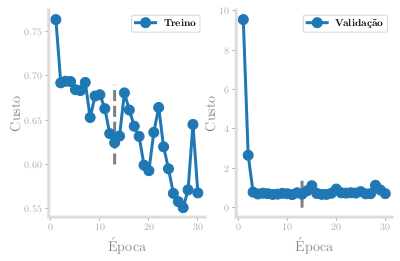

In [163]:
fig, ax = plt.subplots(1, 2, figsize=set_size(445))

results_df[["step", "loss_train"]].dropna().set_index("step").plot(ax=ax[0], marker="o")
results_df[["step", "loss_validation"]].dropna().set_index("step").plot(ax=ax[1], marker="o")

ax[0].set_xlabel("Época")
ax[0].set_ylabel("Custo")
     
ax[1].set_xlabel("Época")
ax[1].set_ylabel("Custo")

ax[0].legend(["Treino"])
ax[1].legend(["Validação"])

ax[0].vlines(x=13, ymin=0.60, ymax=0.69, color="gray", linestyles="--")
ax[1].vlines(x=13, ymin=0, ymax=1.5, color="gray", linestyles="--")



# plt.legend(["Treino", "Validação"])

# plt.xticks(range(1, 31))

plt.show()

# plt.savefig("loss_3d_new.pgf")

In [164]:
# results_df["auc_train"] = 100*results_df["auc_train"]
# results_df["auc_validation"] = 100*results_df["auc_validation"]

In [165]:
# xy = results_df[["step", "auc_train"]].dropna()
# xy

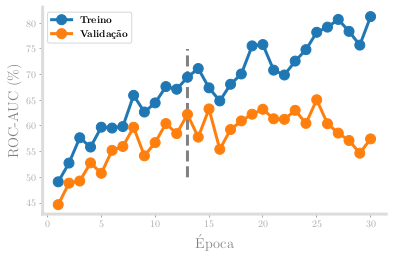

In [166]:
fig, ax = plt.subplots(1, 1, figsize=set_size(445))

# ax = results_df[["step", "auc_train"]].dropna().set_index("step").plot(ax=ax, marker="o")
xy = results_df[["step", "auc_train"]].dropna()
ax.plot(xy["step"], 100*xy["auc_train"], marker="o")

xy = results_df[["step", "auc_validation"]].dropna()
ax.plot(xy["step"], 100*xy["auc_validation"], marker="o")

# results_df[["step", "auc_validation"]].dropna().set_index("step").plot(ax=ax, marker="o")

# plt.xticks(range(1, 31))

ax.vlines(x=13, ymin=50, ymax=75, color="gray", linestyles="--")

plt.xlabel("Época")
plt.ylabel("ROC-AUC (%)")

plt.legend(["Treino", "Validação"])

# plt.show()

# plt.savefig("auc_3d_new.pgf")

# ROC curve

In [172]:
roc_auc_score(results[2][13]["y"], results[2][13]["y_pred"])

0.6835655659477

In [169]:
roc_auc_score(results[3][12]["y"], results[3][12]["y_pred"])

0.5738324175824175

In [178]:
roc_auc_score(results[-1][12]["y"], results[-1][12]["y_pred"])

0.574370709382151

In [72]:
from sklearn.metrics import roc_curve

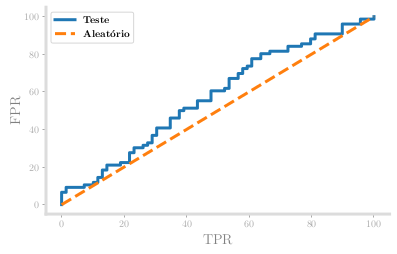

In [175]:
fig, ax = plt.subplots(1, 1, figsize=set_size(445))

# fpr, tpr, thr = roc_curve(results[2][12]["y"], results[2][12]["y_pred"])

# plt.plot(100*fpr, 100*tpr)

# fpr, tpr, thr = roc_curve(results[3][12]["y"], results[3][12]["y_pred"])

# plt.plot(100*fpr, 100*tpr)

fpr, tpr, thr = roc_curve(results[4][12]["y"], results[4][12]["y_pred"])

plt.plot(100*fpr, 100*tpr)

plt.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10), "--")

plt.legend(["Teste", "Aleatório"])

plt.ylabel("FPR")
plt.xlabel("TPR")

plt.savefig("roc_curve_3d.pgf")

Text(0.5, 0, 'TPR')

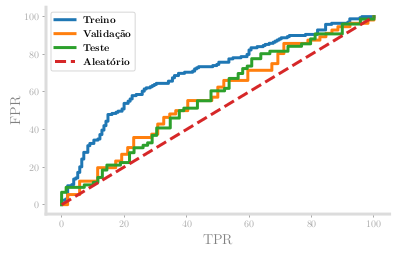

In [136]:
fig, ax = plt.subplots(1, 1, figsize=set_size(445))

fpr, tpr, thr = roc_curve(results[2][12]["y"], results[2][12]["y_pred"])

plt.plot(100*fpr, 100*tpr)

fpr, tpr, thr = roc_curve(results[3][12]["y"], results[3][12]["y_pred"])

plt.plot(100*fpr, 100*tpr)

fpr, tpr, thr = roc_curve(results[4][12]["y"], results[4][12]["y_pred"])

plt.plot(100*fpr, 100*tpr)

plt.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10), "--")

plt.legend(["Treino", "Validação", "Teste", "Aleatório"])

plt.ylabel("FPR")
plt.xlabel("TPR")

# plt.savefig("roc_curve_3d.pgf")

In [131]:
import pickle

In [132]:
# with open('3d.pickle', 'wb') as handle:
#     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    